<a href="https://colab.research.google.com/github/FelipeGBarreto/Projects/blob/master/Clusters_Acidentes_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLUSTERIZANDO OS ACIDENTES NAS RODOVIAS FEDERAIS DO BRASIL**

# **Método Não Hierárquico**
> Optei pelo um método não hierárquico de análise não supervisionada, devido ao fato de a base de dados ser bem expressiva, o que não performaria bem para um método hierárquico.

**OBJETIVO:** Identificar grupos com características semelhantes com relação a acidentes no Brasil nas rodovias federais, objetivando possíveis políticas de trânsito para atacar e diminuir os acidentes.

## Instalando e carregando os pacotes necessários

In [ ]:
pacotes <- c("tidyverse","cluster","dendextend","factoextra","fpc","gridExtra",
             "readxl","ggplot2","tibble")

if(sum(as.numeric(!pacotes %in% installed.packages())) != 0){
  instalador <- pacotes[!pacotes %in% installed.packages()]
  for(i in 1:length(instalador)) {
    install.packages(instalador, dependencies = T)
    break()}
  sapply(pacotes, require, character = T) 
} else {
  sapply(pacotes, require, character = T) 
}

## Utilizando o método k-means
> Procurando a melhor posição para os centróides dos grupos a serem formados;

> Quanto os clusters não ocorrem naturalmente, o algoritmo tende a dividir a tabela em partes iguais.

In [17]:
acidentes <- read.table("/content/Acidentes nas Rodovias Federais - 2007 a 2020.txt", sep=";", dec=",", header = T)
head(acidentes, 3)

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,⋯,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,Ordem_Semana,Ano,Mes
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,10.0,2007-11-06,Segunda,15:30:00,MG,381,623.2,OLIVEIRA,Falta de atenção,Colisão frontal,⋯,0,4,0,5,0,4,6,1,2007,11
2,10.0,2007-11-06,Segunda,15:30:00,MG,381,623.2,OLIVEIRA,Falta de atenção,Colisão frontal,⋯,0,4,0,5,0,4,6,1,2007,11
3,1032898.0,2007-08-13,Segunda,14:25:00,MG,40,585.5,ITABIRITO,Outras,Saída de Pista,⋯,0,0,1,2,0,1,1,1,2007,8


### Separando as variáveis métricas para verificação dos grupos
> As variáveis categóricas servirão para analisar características dos grupos formados.

In [45]:
# colunas desejadas
acidentes_t <- acidentes[, c("municipio","pessoas","mortos","feridos_leves","feridos_graves",
                             "ilesos","ignorados","feridos","veiculos")]

# removendo os espaços em branco
acidentes_t$municipio <- str_replace_all(acidentes_t$municipio, fixed(" "), "")

# somando os valores por município para deixá-los como unique
acidentes_sum <- acidentes_t %>% group_by(municipio) %>% summarise(across(everything(), list(sum)))
acidentes_sum <- acidentes_sum %>% column_to_rownames("municipio") %>% unique()

In [46]:
# Padronizando a base
acidentes_sum_pad <- scale(acidentes_sum) 

# Substituindo os valores NA por 0, que é a média padronizada da distribuição padrão, para que a análise não saia enviesada
acidentes_sum_pad <- replace(x = acidentes_sum_pad, list = is.na(acidentes_sum_pad), values = 0) 

### Verificando possíveis quantidades de clusters com o método Elbow

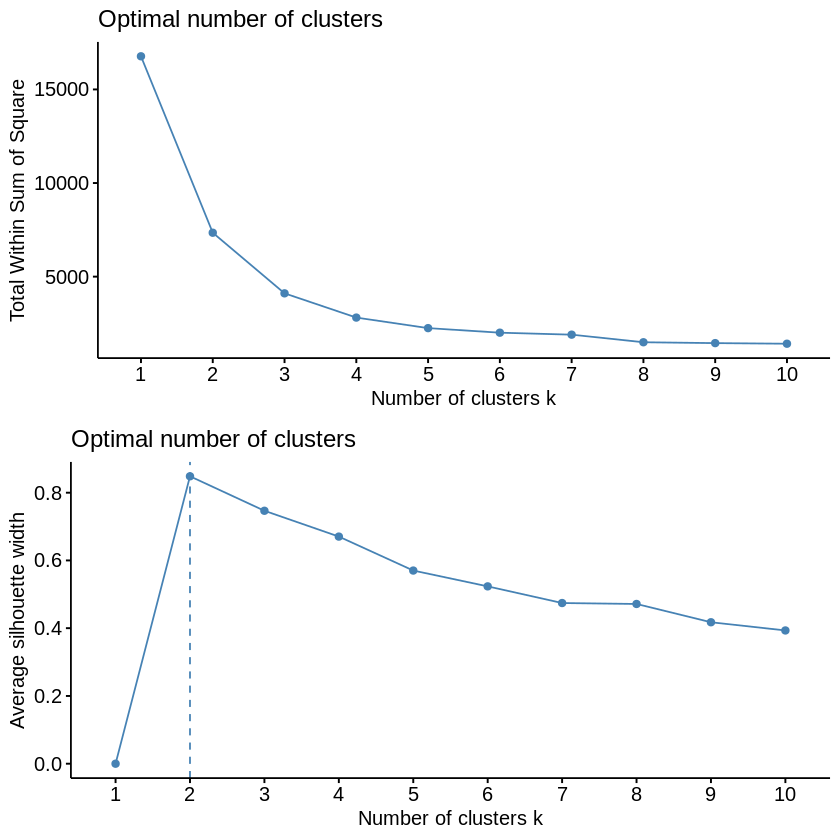

In [47]:
grid.arrange(
  fviz_nbclust(acidentes_sum_pad, kmeans, method = "wss"), # Método Elbow (cotovelo)
  fviz_nbclust(acidentes_sum_pad, kmeans, method = "silhouette") # Método da Silhouette
  )

### Rodando de 3 a 6 centros para visualizar qual a melhor divisão a ser feita

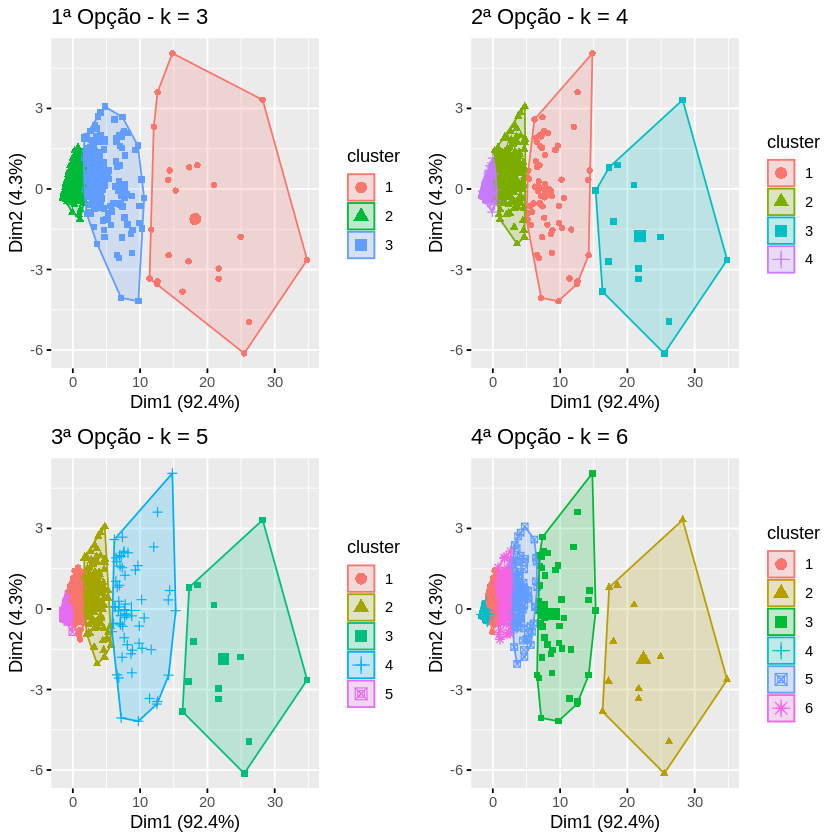

In [48]:
# Criando duas listas para armazenar as opções de clusters e de plots deles
opc_cluster <- list()
graph <- list()

for(i in 1:6){
  opc_cluster[[i]] <- kmeans(acidentes_sum_pad, centers = i + 2)
  graph[[i]] <- fviz_cluster(opc_cluster[[i]], geom = "point", data = acidentes_sum_pad) + ggtitle(paste(i, "ª Opção - k = ",i+2, sep=""))
}

# Plotando as possibilidades predefinidas
grid.arrange(graph[[1]], graph[[2]], graph[[3]], graph[[4]], nrow = 2)

# Outra forma mais manual para fazer
# municip.k4 <- kmeans(acidentes_sum_pad, centers = 4) # Já não tem na, mas se tivesse eu poderia utilizar na.omit(dataset)
# G1 <- fviz_cluster(municip.k4, geom = "point", data = acidentes_sum_pad) + ggtitle("k = 4")
# grid.arrange(G1, G2, G3, G4, nrow = 2)

- Analisando a variabilidade, escolhi 5 grupos para trabalhar

In [49]:
# Armazenando a 3ª opção escolhida (5 clusters)
municip.k5 <- opc_cluster[[3]]

### Juntando os dados

In [50]:
acidentes_clusters <- cbind(acidentes_sum, data.frame(municip.k5$cluster))
acidentes_clusters[sample(nrow(acidentes_clusters),5), ]

,pessoas_1,mortos_1,feridos_leves_1,feridos_graves_1,ilesos_1,ignorados_1,feridos_1,veiculos_1,municip.k5.cluster
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
BARRODURO,283,26,90,50,105,12,140,174,5
OUREM,33,1,9,12,8,3,21,16,5
CRUZEIRODOOESTE,32,4,10,9,9,0,19,19,5
RIOPIRACICABA,7,0,3,0,3,1,3,7,5
ARATACA,1792,77,442,136,1088,49,578,1202,1


### Média dos clusters criados

In [51]:
# Médias por grupo
acidentes_clusters %>% group_by("Grupos" = municip.k5.cluster) %>% 
    summarise("Quantidade"=n() ,across(everything(), list(mean)))

Grupos,Quantidade,pessoas_1_1,mortos_1_1,feridos_leves_1_1,feridos_graves_1_1,ilesos_1_1,ignorados_1_1,feridos_1_1,veiculos_1_1,municip.k5.cluster_1,Quantidade_1
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,475,2230.9137,73.08632,557.04421,208.68842,1305.8695,86.17053,765.7326,1654.8442,1,475
2,166,6362.2229,134.55422,1508.33735,506.42771,3952.7470,260.03012,2014.7651,5030.1566,2,166
3,13,37909.5385,408.53846,7654.15385,2244.53846,25650.6154,1950.15385,9898.6923,32784.0000,3,13
4,60,15688.0167,225.45000,3186.16667,1026.76667,10544.6667,704.56667,4212.9333,13385.8333,4,60
5,1383,359.2242,16.72017,95.79754,39.42299,191.9754,15.30513,135.2205,251.3543,5,1383


**OBSERVAÇÃO:** Há dois clusters que merecem ser estudados com maiores detalhes, os quais são:
- Grupo 3: esse grupo tem a menor quantidade de municipios, mas a maior quantidade de mortes em média ao longo do tempo;

- Grupo 5: comportamento oposto ao grupo 3.

### Análise do menor cluster

In [53]:
# cluster_3 <- acidentes_clusters[acidentes_clusters$municip.k5.cluster == 3, ] %>% rownames_to_column("Municipios")
# cluster_3_municipios <- acidentes[(acidentes$municipio %in% cluster_3$Municipios), ]
# write_csv2(cluster_3_municipios, "Acidentes_cluster_3.csv")